<a href="https://colab.research.google.com/github/ag4267research1/Hybrid-Quantum-PDE-constrained-Optimization/blob/main/Quantum_Algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qiskit qiskit-aer
!pip install qiskit[visualization]


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 67.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 98.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 77.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=828ff9585e0d9e14924b074947922acc81608420a9650053e278da4660cf4033
  Stored in directory: /root/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
Successfully built pylatexenc


In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

from qiskit.circuit.library import QFTGate, RZGate, RYGate, ZGate, HGate
from qiskit_aer import Aer
from qiskit import transpile
import numpy as np


In [ ]:

def qpe_general(unitary_gate, num_ancillas):
    """
    General Quantum Phase Estimation (QPE) circuit.
    Works for ANY unitary gate U.

    Args:
        unitary_gate: qiskit Gate (unitary) acting on system qubits.
        num_ancillas: number of ancilla qubits for precision.

    Returns:
        A QuantumCircuit implementing QPE.
    """



    num_system_qubits = unitary_gate.num_qubits

    anc = QuantumRegister(num_ancillas, 'anc')
    sys = QuantumRegister(num_system_qubits, 'sys')
    c_anc = ClassicalRegister(num_ancillas, 'c_anc')
    qc = QuantumCircuit(anc, sys, c_anc)

    # 1. Hadamards on all ancillas
    for q in range(num_ancillas):
        qc.h(anc[q])

    # 2. Controlled-U^(2^k)
    for k in range(num_ancillas):
        reps = 2 ** k
        for _ in range(reps):
            qc.append(
                unitary_gate.control(1),
                [anc[k]] + list(sys)   # this fixes the TypeError
            )

    # 3. Inverse QFT on ancilla register
    qft = QFTGate(num_ancillas)
    iqft = qft.inverse()

    qc.append(iqft, anc)

    # 4. Measurement
    qc.measure(anc, c_anc)

    return qc

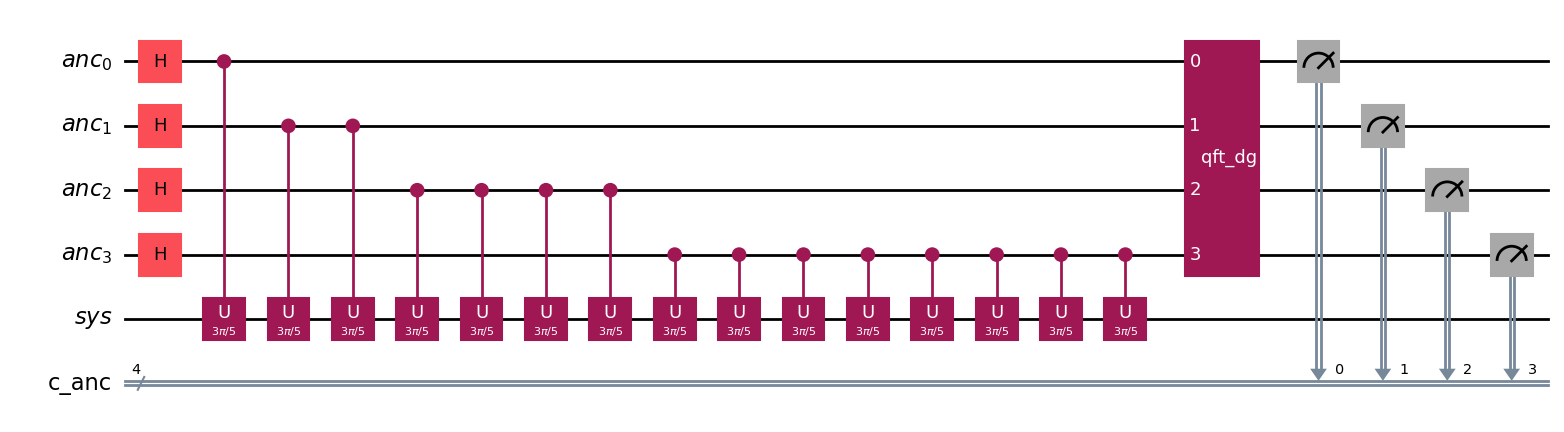

In [ ]:

theta = 0.3
U_gate = RZGate(2*np.pi*theta)
U_gate.label = "U"

qc = qpe_general(U_gate, num_ancillas=4)
qc.draw('mpl')

# QLSA

We take a $2 \times 2$ Hermitian matrix that is diagonal in the computational basis:

$$
A=\left(\begin{array}{ll}
1 & 0 \\
0 & 2
\end{array}\right)
$$


So:
- eigenvectors: $|0\rangle,|1\rangle$
- eigenvalues: $\lambda_0=1, \lambda_1=2$.

We pick a normalized right-hand side as a quantum state:

$$
|b\rangle=|+\rangle=\frac{|0\rangle+|1\rangle}{\sqrt{2}} .
$$


We want to solve:

$$
A x=b .
$$


Classically:

$$
x=A^{-1} b=\left(\begin{array}{cc}
1 & 0 \\
0 & 1 / 2
\end{array}\right) \frac{1}{\sqrt{2}}\binom{1}{1}=\frac{1}{\sqrt{2}}\binom{1}{1 / 2} .
$$


As a quantum state we only care about the direction, so:

$$
|x\rangle \propto \frac{1}{\sqrt{2}}\binom{1}{1 / 2}=\binom{1}{1 / 2} \quad \text { (up to normalization). }
$$


So QLSA should produce a state close to

$$
|x\rangle \approx \frac{1}{\sqrt{1+(1 / 2)^2}}\left(|0\rangle+\frac{1}{2}|1\rangle\right) .
$$

In [ ]:
# ---------------------------------------------------------
# 1. Registers: phase ancilla, system, rotation ancilla, classical bits
# ---------------------------------------------------------

anc_phase = QuantumRegister(1, 'anc_phase')
sys       = QuantumRegister(1, 'sys')
rot       = QuantumRegister(1, 'rot')
c_sys     = ClassicalRegister(1, 'c_sys')
c_rot     = ClassicalRegister(1, 'c_rot')

qc = QuantumCircuit(anc_phase, sys, rot, c_sys, c_rot)

In [ ]:
# ---------------------------------------------------------
# 2. Prepare system in |b> = |+> = (|0> + |1>)/sqrt(2)
# ---------------------------------------------------------

qc.h(sys[0])   # |0> -> |+>

In [ ]:
# ---------------------------------------------------------
# 3. QPE-like encoding with U = Z on the system
#    Steps for 1-qubit QPE:
#      H on anc_phase
#      controlled-Z (anc_phase control, sys target)
#      H on anc_phase  (acts like inverse QFT for 1 qubit)
# ---------------------------------------------------------

# H on phase ancilla
qc.h(anc_phase[0])

# controlled-Z: control=anc_phase, target=sys
# Z gate already acts as its own adjoint and has eigenvalues 1 and -1
qc.cz(anc_phase[0], sys[0])

# H on phase ancilla (inverse QFT for 1 bit)
qc.h(anc_phase[0])

# At this point, phase ancilla encodes which eigenvalue we had (0 or π)


In [ ]:
# ---------------------------------------------------------
# 4. Controlled rotation on the rotation ancilla based on phase ancilla
#    We choose C = 1/2, so:
#      λ0 = 1 -> C/λ0 = 1/2,  θ0 = 2 arcsin(1/2) = 2 * π/6 = π/3
#      λ1 = 2 -> C/λ1 = 1/4,  θ1 = 2 arcsin(1/4)
# ---------------------------------------------------------

C = 0.5
lambda0 = 1.0
lambda1 = 2.0

theta0 = 2 * np.arcsin(C / lambda0)  # for eigenvalue 1
theta1 = 2 * np.arcsin(C / lambda1)  # for eigenvalue 2

# We implement:
# if phase ancilla == 0: apply RY(theta0) on rot
# if phase ancilla == 1: apply RY(theta1) on rot

# Condition ancilla == 0:
#   Use X, controlled RY, then X to "invert" the control.
qc.x(anc_phase[0])
qc.append(RYGate(theta0).control(1), [anc_phase[0], rot[0]])
qc.x(anc_phase[0])

# Condition ancilla == 1:
qc.append(RYGate(theta1).control(1), [anc_phase[0], rot[0]])



In [ ]:

# ---------------------------------------------------------
# 5. Inverse QPE
# ---------------------------------------------------------

qc.h(anc_phase[0])
qc.cz(anc_phase[0], sys[0])
qc.h(anc_phase[0])



In [ ]:

# ---------------------------------------------------------
# 6. Measurements
# ---------------------------------------------------------

qc.measure(rot[0], c_rot[0])
qc.measure(sys[0], c_sys[0])

print(qc.draw(output='text'))


           ┌───┐   ┌───┐┌───┐┌───┐┌───┐           ┌───┐               ┌───┐   »
anc_phase: ┤ H ├─■─┤ H ├┤ X ├┤ X ├┤ X ├─────■─────┤ X ├───────■───────┤ H ├─■─»
           ├───┤ │ └───┘└───┘└───┘└───┘     │     └───┘       │       └───┘ │ »
      sys: ┤ H ├─■──────────────────────────┼─────────────────┼─────────────■─»
           └───┘                       ┌────┴────┐     ┌──────┴──────┐ ┌─┐    »
      rot: ────────────────────────────┤ Ry(π/3) ├─────┤ Ry(0.50536) ├─┤M├────»
                                       └─────────┘     └─────────────┘ └╥┘    »
  c_sys: 1/═════════════════════════════════════════════════════════════╬═════»
                                                                        ║     »
  c_rot: 1/═════════════════════════════════════════════════════════════╩═════»
                                                                        0     »
«           ┌───┐
«anc_phase: ┤ H ├
«           └┬─┬┘
«      sys: ─┤M├─
«            └╥┘ 
«      rot: ──╫──
«           

In [ ]:

# ---------------------------------------------------------
# 7. Run on Aer simulator
# ---------------------------------------------------------

backend = Aer.get_backend("qasm_simulator")
qc_compiled = transpile(qc, backend)
result = backend.run(qc_compiled, shots=8192).result()
counts = result.get_counts()

print("\nMeasurement counts:")
print(counts)


Measurement counts:
{'1 1': 260, '0 1': 3886, '1 0': 1004, '0 0': 3042}
